In [3]:
# import statements
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.data import Dataset
# (Beans used tfds; CIFAR-10 comes from Keras directly)
# !pip install tensorflow_datasets
# import tensorflow_datasets as tfds  # kept for parity with reference (not used for CIFAR-10)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random


In [4]:
# CIFAR-10 Dataset
# The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes (50k train / 10k test).
# We'll mirror the Beans workflow (train/val/test, preview, preprocessing, models, augmentation, TL).
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape,  y_test.shape)

# CIFAR-10 label names
cifar10_names = ["airplane","automobile","bird","cat","deer",
                 "dog","frog","horse","ship","truck"]

# show one example like the Beans code does
print("Example image dtype/shape and label:")
print(x_train[0].dtype, x_train[0].shape, int(y_train[0]))


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Train: (50000, 32, 32, 3) (50000, 1)
Test : (10000, 32, 32, 3) (10000, 1)
Example image dtype/shape and label:
uint8 (32, 32, 3) 6


C:\Users\james\AppData\Local\Temp\ipykernel_69208\3053010503.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(x_train[0].dtype, x_train[0].shape, int(y_train[0]))


C:\Users\james\AppData\Local\Temp\ipykernel_69208\365788271.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels.append(int(y_train[i]))


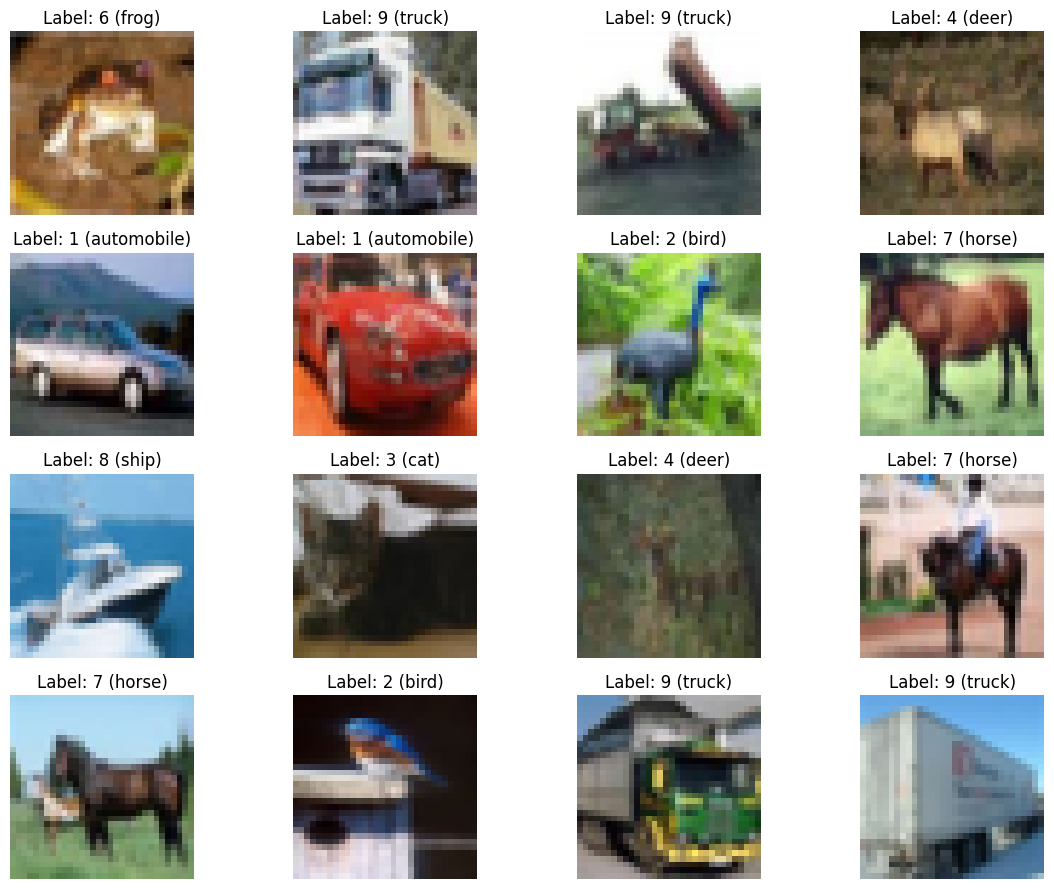

In [5]:
# get the first 16 images and labels from the training set (preview, like Beans)
images, labels = [], []
for i in range(16):
    images.append(x_train[i])
    labels.append(int(y_train[i]))

# plot the first 16 images
fig, axes = plt.subplots(4, 4, figsize=(12, 9))
axes = axes.flatten()
for i in range(16):
    ax = axes[i]
    ax.imshow(images[i])
    ax.set_title(f"Label: {labels[i]} ({cifar10_names[labels[i]]})")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [6]:
# function to preprocess the images (resize and normalize)
# We will mirror the Beans approach (resize + normalize + one-hot)
NUM_CLASSES = 10

def preprocess_image(image, label, target_size=(128, 128)):
    image = tf.image.resize(image, target_size)         # resize image
    image = tf.cast(image, tf.float32) / 255.0          # normalize to [0, 1]
    label = tf.one_hot(tf.squeeze(label), depth=NUM_CLASSES)  # one-hot encode labels (10 classes)
    return image, label

# Build train/val/test tf.data pipelines
# Beans provided an explicit validation split; CIFAR-10 doesn't, so we create a 20% val split from training.
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

ds_all = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_all = ds_all.shuffle(buffer_size=len(x_train), seed=seed_value, reshuffle_each_iteration=False)
val_size = int(0.20 * len(x_train))  # 20% validation
val_data_raw = ds_all.take(val_size)
train_data_raw = ds_all.skip(val_size)

test_data_raw = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Apply preprocessing like Beans
train_data = train_data_raw.map(lambda x, y: preprocess_image(x, y)).batch(32).prefetch(tf.data.AUTOTUNE)
val_data   = val_data_raw.map(lambda x, y: preprocess_image(x, y)).batch(32).prefetch(tf.data.AUTOTUNE)
test_data  = test_data_raw.map(lambda x, y: preprocess_image(x, y)).batch(32).prefetch(tf.data.AUTOTUNE)


In [7]:
# Define the CNN (mirroring the reference structure, but with 10 classes)
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # 30% dropout
    layers.Dense(NUM_CLASSES, activation='softmax')  # 10 classes for CIFAR-10
])

# Compile and train (≤ 10 epochs as required)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # because we one-hot encoded
    metrics=['accuracy']
)
history = model.fit(train_data, validation_data=val_data, epochs=10, verbose=1)

# Evaluate
test_loss, test_acc = model.evaluate(test_data, verbose=0)
print(f"Test Accuracy (baseline): {test_acc:.2f}")


Epoch 1/10


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 100s 79ms/step - accuracy: 0.4153 - loss: 1.6132 - val_accuracy: 0.5509 - val_loss: 1.2383
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.5565 - loss: 1.2406 - val_accuracy: 0.6227 - val_loss: 1.0566
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 198s 158ms/step - accuracy: 0.6269 - loss: 1.0491 - val_accuracy: 0.6498 - val_loss: 0.9972
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 131s 104ms/step - accuracy: 0.6748 - loss: 0.9162 - val_accuracy: 0.6584 - val_loss: 0.9813
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 95s 76ms/step - accuracy: 0.7117 - loss: 0.8087 - val_accuracy: 0.6498 - val_loss: 1.0646
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 93s 75ms/step - accuracy: 0.7411 - loss: 0.7134 - val_accuracy: 0.6631 - val_loss: 1.0234
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 78ms/step - accuracy: 0.7712 - loss: 0.6319 - val_accuracy: 0.6721 - val_loss: 1.0468
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.7986 - loss:

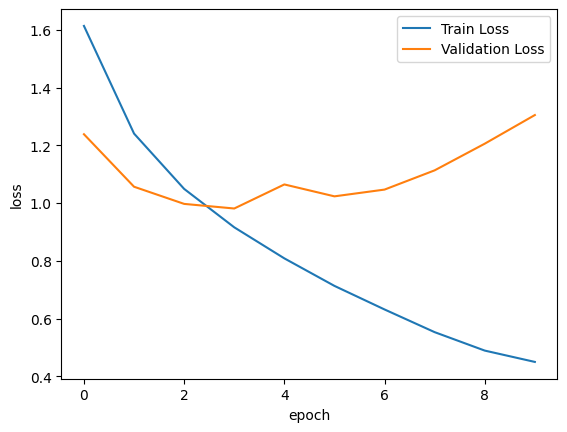

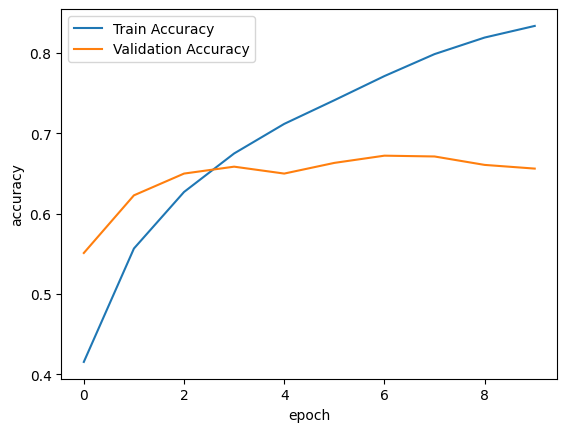

In [8]:
# plot of train/validation loss to determine fit (same style as reference)
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch

# Train/Val Loss
sns.lineplot(x='epoch', y='loss', data=train_history, label='Train Loss')
sns.lineplot(x='epoch', y='val_loss', data=train_history, label='Validation Loss')
plt.legend()
plt.show()

# Train/Val Accuracy
sns.lineplot(x='epoch', y='accuracy', data=train_history, label='Train Accuracy')
sns.lineplot(x='epoch', y='val_accuracy', data=train_history, label='Validation Accuracy')
plt.legend()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.105351925..0.9117922].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.056343734..0.88658446].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0441998].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0838968].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02768594..0.8978518].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012981057..0.99892724].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04744661..0

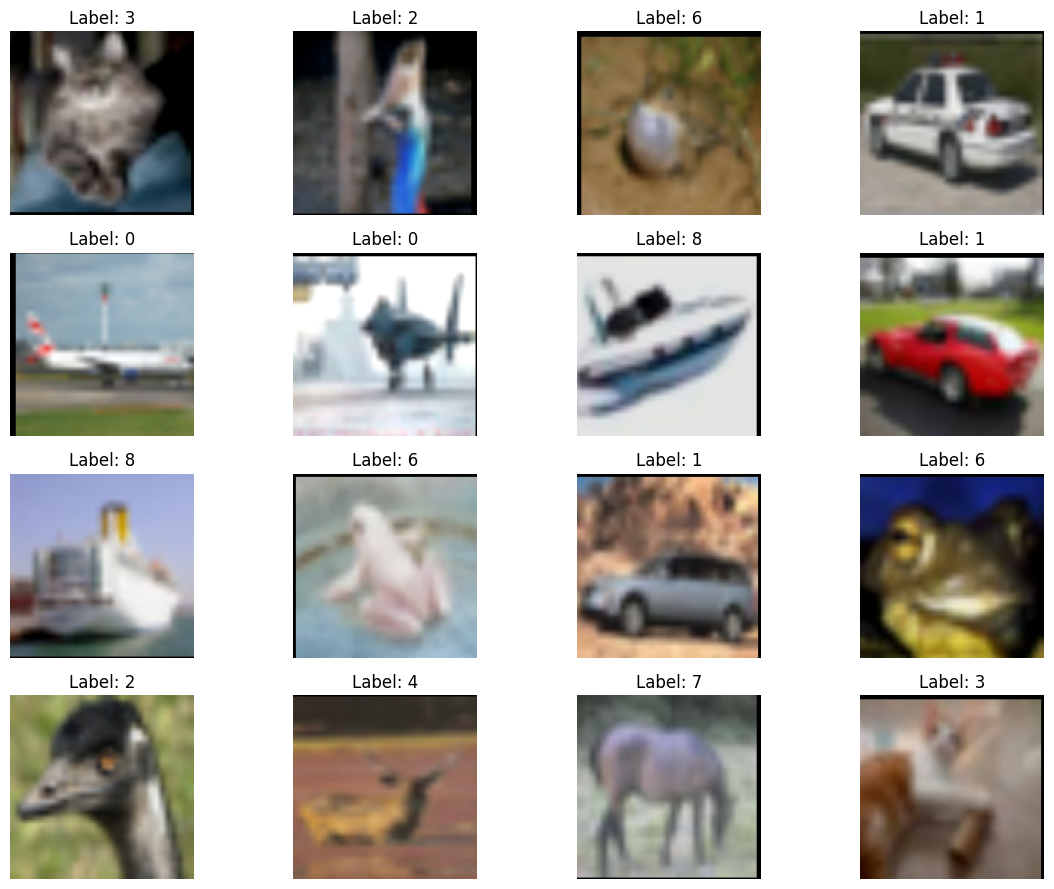

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 76ms/step - accuracy: 0.6827 - loss: 0.9439 - val_accuracy: 0.6911 - val_loss: 0.9096
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 110s 88ms/step - accuracy: 0.7408 - loss: 0.7402 - val_accuracy: 0.6907 - val_loss: 0.9574
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - accuracy: 0.7791 - loss: 0.6151 - val_accuracy: 0.6907 - val_loss: 0.9846
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 92ms/step - accuracy: 0.8121 - loss: 0.5190 - val_accuracy: 0.6885 - val_loss: 1.0927
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 92s 73ms/step - accuracy: 0.8353 - loss: 0.4507 - val_accuracy: 0.6799 - val_loss: 1.1913
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 93s 74ms/step - accuracy: 0.8547 - loss: 0.3972 - val_accuracy: 0.6759 - val_loss: 1.2313
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.8701 - loss: 0.3543 - val_accuracy: 0.6767 - val_loss: 1.3354
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 95s 76ms/step - accuracy: 0.87

In [9]:
# Augmentation to Improve Accuracy (text kept in spirit of reference)
# We'll mirror the two augmentation approaches from the reference:
# (1) tf.image-based ops inside preprocess function (flag augment=True)
# (2) Keras built-in augmentation layers sequence (preferred and cleaner)

# ------------- (1) tf.image augmentation version -------------
def preprocess_image(image, label, target_size=(128, 128), augment=False):
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0

    if augment:
        # apply data augmentation (kept gentle for CIFAR-10)
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.10)
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
        image = tf.image.random_crop(
            tf.image.resize_with_crop_or_pad(image, target_size[0] + 8, target_size[1] + 8),
            size=target_size + (3,)
        )

    label = tf.one_hot(tf.squeeze(label), depth=NUM_CLASSES)
    return image, label

train_data_aug = train_data_raw.map(lambda x, y: preprocess_image(x, y, augment=True)).batch(32).prefetch(tf.data.AUTOTUNE)
val_data_aug   = val_data_raw.map(lambda x, y: preprocess_image(x, y, augment=False)).batch(32).prefetch(tf.data.AUTOTUNE)
test_data_aug  = test_data_raw.map(lambda x, y: preprocess_image(x, y, augment=False)).batch(32).prefetch(tf.data.AUTOTUNE)

# Visualize augmented samples (first batch)
aug_imgs, aug_labels = next(iter(train_data_aug))
fig, axes = plt.subplots(4, 4, figsize=(12, 9))
axes = axes.flatten()
for i in range(16):
    ax = axes[i]
    ax.imshow(aug_imgs[i])
    ax.set_title(f"Label: {tf.argmax(aug_labels[i]).numpy()}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Re-train same model architecture with augmented data
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_aug = model.fit(train_data_aug, validation_data=val_data_aug, epochs=10, verbose=1)

test_loss2, test_acc2 = model.evaluate(test_data_aug, verbose=0)
print(f"Test Accuracy (tf.image augmentation): {test_acc2:.2f}")


In [10]:
# ------------- (2) Keras Sequential augmentation version -------------
target_size = (128, 128)

augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed=42),
    layers.RandomBrightness(factor=0.10, value_range=(0.0, 1.0), seed=42),
    layers.RandomContrast(factor=0.10, value_range=(0.0, 1.0), seed=42),
    layers.RandomZoom(height_factor=(-0.08, 0.0), width_factor=(-0.08, 0.0), seed=42),
], name="augmentation")

def preprocess_image_for_aug_layer(image, label, target_size=(128, 128)):
    # Keep [0,1] scale for the RandomBrightness/Contrast value_range
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    # label sparse here to show parity with reference’s second variant later
    return image, tf.squeeze(label)

train_data_kaug = train_data_raw.map(preprocess_image_for_aug_layer).batch(32).prefetch(tf.data.AUTOTUNE)
val_data_kaug   = val_data_raw.map(preprocess_image_for_aug_layer).batch(32).prefetch(tf.data.AUTOTUNE)
test_data_kaug  = test_data_raw.map(preprocess_image_for_aug_layer).batch(32).prefetch(tf.data.AUTOTUNE)

# Model with augmentation and sparse labels (like reference "preference inside model" section)
model_kaug = tf.keras.Sequential([
    tf.keras.Input(shape=(None, None, 3), dtype='float32'),
    layers.Resizing(128, 128),  # already float32 in [0,1]
    augmentation,

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax'),
])

model_kaug.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",  # sparse labels
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history_kaug = model_kaug.fit(train_data_kaug, validation_data=val_data_kaug, epochs=10, callbacks=callbacks, verbose=1)
test_loss3, test_acc3 = model_kaug.evaluate(test_data_kaug, verbose=0)
print(f"Test Accuracy (Keras aug layer + sparse labels): {test_acc3:.2f}")


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 85ms/step - accuracy: 0.4086 - loss: 1.6221 - val_accuracy: 0.4872 - val_loss: 1.4114 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 99s 79ms/step - accuracy: 0.5263 - loss: 1.3159 - val_accuracy: 0.5848 - val_loss: 1.1464 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 101s 81ms/step - accuracy: 0.5807 - loss: 1.1793 - val_accuracy: 0.6201 - val_loss: 1.0850 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 102s 81ms/step - accuracy: 0.6252 - loss: 1.0666 - val_accuracy: 0.6569 - val_loss: 0.9881 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 102s 81ms/step - accuracy: 0.6549 - loss: 0.9844 - val_accuracy: 0.6738 - val_loss: 0.9472 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 99s 79ms/step - accuracy: 0.6800 - loss: 0.9124 - val_accuracy: 0.6804 - val_loss: 0.9348 - learning_rate: 0.0010
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 98s 78ms/step - ac

In [14]:
from tensorflow.keras import applications as A
from tensorflow.keras import backend as K
from tensorflow.keras import layers
import tensorflow as tf

NUM_CLASSES = 10
IMG = 160
USE_MODEL = "EfficientNetB0"   # or "MobileNetV2" / "EfficientNetV2B0"

# choose preprocess + constructor
if USE_MODEL == "EfficientNetB0":
    preprocess_input = A.efficientnet.preprocess_input
    Base = A.EfficientNetB0
elif USE_MODEL == "MobileNetV2":
    preprocess_input = A.mobilenet_v2.preprocess_input
    Base = A.MobileNetV2
elif USE_MODEL == "EfficientNetV2B0":
    preprocess_input = A.efficientnet_v2.preprocess_input
    Base = A.EfficientNetV2B0
else:
    raise ValueError("Unknown model")

def ensure_rgb(img):
    img = tf.convert_to_tensor(img)

    # If rank is 2 (H, W), add 3 identical channels
    img = tf.cond(
        tf.equal(tf.rank(img), 2),
        lambda: tf.stack([img, img, img], axis=-1),
        lambda: img
    )

    # If last dim is 1 (H, W, 1), convert to RGB
    img = tf.cond(
        tf.equal(tf.shape(img)[-1], 1),
        lambda: tf.image.grayscale_to_rgb(img),
        lambda: img
    )
    return img

# robust preprocessing for TL
def tl_preprocess(image, label):
    image = ensure_rgb(image)
    image = tf.image.resize(image, (IMG, IMG))
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)  # model-specific scaling
    return image, tf.squeeze(label)

train_tl = train_data_raw.map(tl_preprocess).batch(64).prefetch(tf.data.AUTOTUNE)
val_tl   = val_data_raw.map(tl_preprocess).batch(64).prefetch(tf.data.AUTOTUNE)
test_tl  = test_data_raw.map(tl_preprocess).batch(64).prefetch(tf.data.AUTOTUNE)

# build base with input_tensor to lock (IMG, IMG, 3)
inputs = tf.keras.Input(shape=(IMG, IMG, 3))
base_model = Base(include_top=False, weights="imagenet", input_tensor=inputs)
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
tl_model = tf.keras.Model(inputs=inputs, outputs=outputs)

tl_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

# sanity checks
for bimgs, _ in train_tl.take(1):
    tf.print("Batch to TL:", tf.shape(bimgs))  # should be [N, 160, 160, 3]

history_tl = tl_model.fit(train_tl, validation_data=val_tl, epochs=3, verbose=1)
test_loss_tl, test_acc_tl = tl_model.evaluate(test_tl, verbose=0)
print(f"Test Accuracy (TL frozen): {test_acc_tl:.3f}")


ValueError: in user code:

    File "C:\Users\james\AppData\Local\Temp\ipykernel_69208\874034614.py", line 44, in tl_preprocess  *
        image = tf.image.resize(image, (IMG, IMG))

    ValueError: 'images' contains no shape.


In [ ]:
# (Optional) Collect histories into a single DataFrame for easy comparison in your report
def summarize_history(name, hist):
    df = pd.DataFrame(hist.history).copy()
    df['epoch'] = hist.epoch if hasattr(hist, 'epoch') else range(len(df))
    df['run'] = name
    return df

dfs = []
if 'history' in globals():      dfs.append(summarize_history("baseline_onehot", history))
if 'history_aug' in globals():  dfs.append(summarize_history("tfimage_aug", history_aug))
if 'history_kaug' in globals(): dfs.append(summarize_history("keras_aug_sparse", history_kaug))
if 'history_tl' in globals():   dfs.append(summarize_history("transfer_learning", history_tl))
compare_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
compare_df.head()


In [ ]:
# (Optional) Plot accuracy comparison across runs (if you executed multiple)
if not compare_df.empty:
    plt.figure(figsize=(8,5))
    for name, g in compare_df.groupby('run'):
        plt.plot(g['epoch'], g['val_accuracy'], label=f'{name} val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Val Accuracy'); plt.legend(); plt.title('Validation Accuracy Across Variants')
    plt.show()
